# Personality Prediction Framework (v3.0) - with Doc2Vec

Developed by: R.T.R Jayasekara

## Required Libraries

In [5]:
import pandas
import numpy
import os
import warnings
import pickle
import re
import unidecode
import nltk
import spacy
import gensim
import multiprocessing
from spacy.lang.en.stop_words import STOP_WORDS
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

# Python -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm")

# Download NLTK words corpora
#nltk.download('words')
# import nltk
# nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
from sklearn import utils
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## Preprocessor

In order to work with text data, it is important to transform the raw text into a form that can be understood and used by Machine Learning algorithms, this is called preprocessing.

### Normalizer

In [2]:
def normalizer(text):
    # Handle foreign letters
    text = unidecode.unidecode(text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Make the string lower-case
    text = text.lower()

    tokens = nlp(text)
    
    words = set(nltk.corpus.words.words())

    tokens = [ti for ti in tokens if ti.lower_ not in STOP_WORDS]
    tokens = [ti for ti in tokens if not ti.is_space]
    tokens = [ti for ti in tokens if not ti.is_punct]
    tokens = [ti for ti in tokens if not ti.like_num]
    tokens = [ti for ti in tokens if not ti.like_url]
    tokens = [ti for ti in tokens if not ti.like_email]
    tokens = [ti for ti in tokens if ti.lower_ in words]

    # lemmatize
    tokens = [ti.lemma_ for ti in tokens if ti.lemma_ not in STOP_WORDS]
    tokens = [ti for ti in tokens if len(ti) > 1]

    return tokens

In [3]:
if __name__ == "__main__":
    status_data = pandas.read_csv("datasets/mypersonality_final.csv")

    # Annotate the status with sentiment scores
    # From nltk.sentiment.vader corpus
    if not os.path.isfile("datasets/mypersonality_tokenized.csv"):
        status_data['TOKENS'] = status_data['STATUS'].apply(normalizer)
        status_data.to_csv('datasets/mypersonality_tokenized.csv')
    else:
        status_data = pandas.read_csv("datasets/mypersonality_tokenized.csv")

In [4]:
# Drop NAs
status_data = status_data.dropna()

# We drop columns which give us a score for personality type
status_data = status_data.drop(['STATUS', '#AUTHID', 'sEXT', 'sNEU', 'sAGR',
                                    'sCON', 'sOPN', 'DATE'], axis=1)

# Drop non-normalized scores of Brokerage and Betweenness
status_data = status_data.drop(['BROKERAGE', 'BETWEENNESS', 'NBROKERAGE',
                                    'NBETWEENNESS', 'DENSITY', 'TRANSITIVITY', 'NETWORKSIZE'], axis=1)

In [5]:
status_data.head(10)

,Unnamed: 0,cEXT,cNEU,cAGR,cCON,cOPN,TOKENS
0,0,n,y,n,n,y,"['sound', 'thunder']"
1,1,n,y,n,n,y,"['sleepy', 'funny', 'sleep']"
2,2,n,y,n,n,y,"['sore', 'knot', 'base', 'neck', 'stop', 'hurt..."
3,3,n,y,n,n,y,"['day', 'new', 'song']"
4,4,n,y,n,n,y,['home']
5,5,n,y,n,n,y,[]
6,6,n,y,n,n,y,"['nun', 'zombie', 'psychic', 'great', 'party']"
7,7,n,y,n,n,y,"['mile', 'journey', 'home']"
8,8,n,y,n,n,y,"['finish', 'digital', 'painting', 'tablet', 'h..."
9,9,n,y,n,n,y,"['new', 'haircut', 'listen', 'swinger', 'music..."


In [6]:
# Change the name of first row to "rowID"
new_columns = status_data.columns.values
new_columns[0] = "rowID"
status_data.columns = new_columns

# Put the columns to be predicted, at the end
cols = status_data.columns.tolist()
cols = cols[:5] + cols[5:10]
status_data = status_data[cols]

In [7]:
status_data.head(10)

,rowID,cEXT,cNEU,cAGR,cCON,cOPN,TOKENS
0,0,n,y,n,n,y,"['sound', 'thunder']"
1,1,n,y,n,n,y,"['sleepy', 'funny', 'sleep']"
2,2,n,y,n,n,y,"['sore', 'knot', 'base', 'neck', 'stop', 'hurt..."
3,3,n,y,n,n,y,"['day', 'new', 'song']"
4,4,n,y,n,n,y,['home']
5,5,n,y,n,n,y,[]
6,6,n,y,n,n,y,"['nun', 'zombie', 'psychic', 'great', 'party']"
7,7,n,y,n,n,y,"['mile', 'journey', 'home']"
8,8,n,y,n,n,y,"['finish', 'digital', 'painting', 'tablet', 'h..."
9,9,n,y,n,n,y,"['new', 'haircut', 'listen', 'swinger', 'music..."


In [8]:
# 'y' for 1 and 'n' for 0
features = ['cEXT', 'cNEU', 'cOPN', 'cAGR', 'cCON']
for feature in features:
    status_data[feature] = status_data[feature].map({'y': 1.0, 'n': 0.0}).astype(int)

In [9]:
status_data.head(10)

,rowID,cEXT,cNEU,cAGR,cCON,cOPN,TOKENS
0,0,0,1,0,0,1,"['sound', 'thunder']"
1,1,0,1,0,0,1,"['sleepy', 'funny', 'sleep']"
2,2,0,1,0,0,1,"['sore', 'knot', 'base', 'neck', 'stop', 'hurt..."
3,3,0,1,0,0,1,"['day', 'new', 'song']"
4,4,0,1,0,0,1,['home']
5,5,0,1,0,0,1,[]
6,6,0,1,0,0,1,"['nun', 'zombie', 'psychic', 'great', 'party']"
7,7,0,1,0,0,1,"['mile', 'journey', 'home']"
8,8,0,1,0,0,1,"['finish', 'digital', 'painting', 'tablet', 'h..."
9,9,0,1,0,0,1,"['new', 'haircut', 'listen', 'swinger', 'music..."


### Vectorizer
**With Doc2Vec**

Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method.

In [10]:
# Split into training and test data: 75% and 25%
train_data, test_data = train_test_split(status_data, test_size=0.25)

In [11]:
train_OPN_tagged = train_data.apply(
    lambda r: TaggedDocument(words=r['TOKENS'], tags=[r.cOPN]), axis=1)
test_OPN_tagged = test_data.apply(
    lambda r: TaggedDocument(words=r['TOKENS'], tags=[r.cOPN]), axis=1)

train_CON_tagged = train_data.apply(
    lambda r: TaggedDocument(words=r['TOKENS'], tags=[r.cCON]), axis=1)
test_CON_tagged = test_data.apply(
    lambda r: TaggedDocument(words=r['TOKENS'], tags=[r.cCON]), axis=1)

train_EXT_tagged = train_data.apply(
    lambda r: TaggedDocument(words=r['TOKENS'], tags=[r.cEXT]), axis=1)
test_EXT_tagged = test_data.apply(
    lambda r: TaggedDocument(words=r['TOKENS'], tags=[r.cEXT]), axis=1)

train_AGR_tagged = train_data.apply(
    lambda r: TaggedDocument(words=r['TOKENS'], tags=[r.cAGR]), axis=1)
test_AGR_tagged = test_data.apply(
    lambda r: TaggedDocument(words=r['TOKENS'], tags=[r.cAGR]), axis=1)

train_NEU_tagged = train_data.apply(
    lambda r: TaggedDocument(words=r['TOKENS'], tags=[r.cNEU]), axis=1)
test_NEU_tagged = test_data.apply(
    lambda r: TaggedDocument(words=r['TOKENS'], tags=[r.cNEU]), axis=1)

#train_OPN_tagged[30]

In [12]:
cores = multiprocessing.cpu_count()
cores

12

In [13]:
# Building Vocabularies
model_OPN_d2v = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_OPN_d2v.build_vocab([x for x in tqdm(train_OPN_tagged.values)])

model_CON_d2v = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_CON_d2v.build_vocab([x for x in tqdm(train_CON_tagged.values)])

model_EXT_d2v = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_EXT_d2v.build_vocab([x for x in tqdm(train_EXT_tagged.values)])

model_AGR_d2v = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_AGR_d2v.build_vocab([x for x in tqdm(train_AGR_tagged.values)])

model_NEU_d2v = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_NEU_d2v.build_vocab([x for x in tqdm(train_NEU_tagged.values)])

100%|██████████| 7437/7437 [00:00<00:00, 2506874.46it/s]


In [14]:
%%time
for epoch in range(30):
    model_OPN_d2v.train(utils.shuffle([x for x in tqdm(train_OPN_tagged.values)]), total_examples=len(train_OPN_tagged.values), epochs=1)
    model_OPN_d2v.alpha -= 0.002
    model_OPN_d2v.min_alpha = model_OPN_d2v.alpha
    
    model_CON_d2v.train(utils.shuffle([x for x in tqdm(train_CON_tagged.values)]), total_examples=len(train_CON_tagged.values), epochs=1)
    model_CON_d2v.alpha -= 0.002
    model_CON_d2v.min_alpha = model_CON_d2v.alpha
    
    model_EXT_d2v.train(utils.shuffle([x for x in tqdm(train_EXT_tagged.values)]), total_examples=len(train_EXT_tagged.values), epochs=1)
    model_EXT_d2v.alpha -= 0.002
    model_EXT_d2v.min_alpha = model_EXT_d2v.alpha
    
    model_AGR_d2v.train(utils.shuffle([x for x in tqdm(train_AGR_tagged.values)]), total_examples=len(train_AGR_tagged.values), epochs=1)
    model_AGR_d2v.alpha -= 0.002
    model_AGR_d2v.min_alpha = model_AGR_d2v.alpha
    
    model_NEU_d2v.train(utils.shuffle([x for x in tqdm(train_NEU_tagged.values)]), total_examples=len(train_NEU_tagged.values), epochs=1)
    model_NEU_d2v.alpha -= 0.002
    model_NEU_d2v.min_alpha = model_NEU_d2v.alpha
    print('---')

100%|██████████| 7437/7437 [00:00<00:00, 2481151.67it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2479770.96it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 3710806.43it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2478982.66it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 3645750.22it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 3719212.93it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2479179.69it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 3718769.53it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2437717.95it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2479179.69it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2478391.77it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2481349.05it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2479376.75it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2506270.20it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2480757.03it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 3718769.53it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2477998.00it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2476227.58it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2478785.67it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 1487507.81it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2479179.69it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 743966.77it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2480165.29it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 3715226.16it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 3719212.93it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2451704.70it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2481349.05it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 3721875.53it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2479179.69it/s]


---


100%|██████████| 7437/7437 [00:00<00:00, 2482533.93it/s]


---
Wall time: 1min


In [15]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector([doc.words], epochs=20)) for doc in sents])
    return targets, regressors

## Data Visualization

In [16]:
cOPN_counts = status_data['cOPN'].value_counts()
print(cOPN_counts)

cCON_counts = status_data['cCON'].value_counts()
print(cCON_counts)

cEXT_counts = status_data['cEXT'].value_counts()
print(cEXT_counts)

cAGR_counts = status_data['cAGR'].value_counts()
print(cAGR_counts)

cNEU_counts = status_data['cNEU'].value_counts()
print(cNEU_counts)

1    7369
0    2547
Name: cOPN, dtype: int64
0    5361
1    4555
Name: cCON, dtype: int64
0    5707
1    4209
Name: cEXT, dtype: int64
1    5267
0    4649
Name: cAGR, dtype: int64
0    6199
1    3717
Name: cNEU, dtype: int64


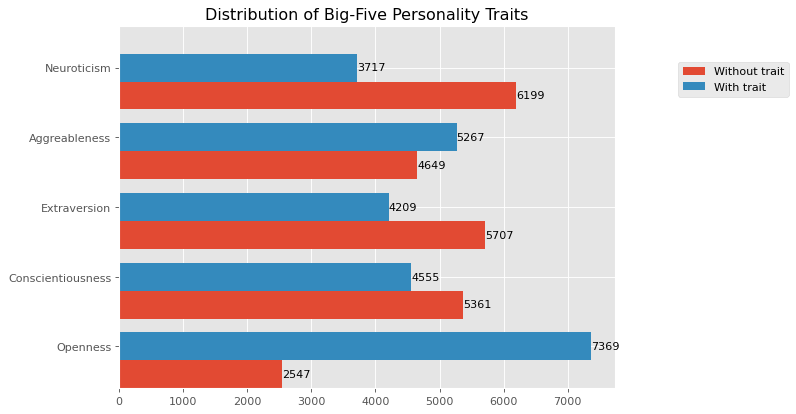

In [17]:
traits = ['Openness', 'Conscientiousness', 'Extraversion', 'Aggreableness', 'Neuroticism']
with_trait_counts = [cOPN_counts[1], cCON_counts[1], cEXT_counts[1], cAGR_counts[1], cNEU_counts[1]]
without_trait_counts = [cOPN_counts[0], cCON_counts[0], cEXT_counts[0], cAGR_counts[0], cNEU_counts[0]]

traits_df = pandas.DataFrame({'with_trait_counts': with_trait_counts, 
                              'without_trait_counts': without_trait_counts,
                              'traits': traits})
ind = numpy.arange(len(traits_df))
width = 0.4

fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
ax.barh(ind, traits_df.without_trait_counts, width, label='Without trait')
ax.barh(ind + width, traits_df.with_trait_counts, width, label='With trait')
ax.set(yticks=ind + width, yticklabels=traits_df.traits, ylim=[2*width - 1, len(traits_df)])
ax.legend(bbox_to_anchor=(1.35, 0.9), loc='upper right', borderaxespad=0)
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')
plt.title('Distribution of Big-Five Personality Traits')
plt.show()


# Machine Learning

In [16]:
def print_classification_reports(output_model_OPN, output_model_CON, output_model_EXT, output_model_AGR, output_model_NEU):
    print('Openness---')
    print(classification_report(test_data.cOPN, output_model_OPN))

    print('Conscientiousness---')
    print(classification_report(test_data.cCON, output_model_CON))

    print('Extraversion---')
    print(classification_report(test_data.cEXT, output_model_EXT))

    print('Aggreableness---')
    print(classification_report(test_data.cAGR, output_model_AGR))

    print('Neuroticism---')
    print(classification_report(test_data.cNEU, output_model_NEU))

In [17]:
def claculate_accuracy_scores(output_model_OPN, output_model_CON, output_model_EXT, output_model_AGR, output_model_NEU):
    model_accuracy = {
        'accuracy_opn': accuracy_score(test_data.cOPN, output_model_OPN),
        'accuracy_con': accuracy_score(test_data.cCON, output_model_CON),
        'accuracy_ext': accuracy_score(test_data.cEXT, output_model_EXT),
        'accuracy_agr': accuracy_score(test_data.cAGR, output_model_AGR),
        'accuracy_neu':accuracy_score(test_data.cNEU, output_model_NEU)
    }
    
    return model_accuracy

In [18]:
y_OPN_train, X_OPN_train = vec_for_learning(model_OPN_d2v, train_OPN_tagged)
y_OPN_test, X_OPN_test = vec_for_learning(model_OPN_d2v, test_OPN_tagged)

y_CON_train, X_CON_train = vec_for_learning(model_CON_d2v, train_CON_tagged)
y_CON_test, X_CON_test = vec_for_learning(model_CON_d2v, test_CON_tagged)

y_EXT_train, X_EXT_train = vec_for_learning(model_EXT_d2v, train_EXT_tagged)
y_EXT_test, X_EXT_test = vec_for_learning(model_EXT_d2v, test_EXT_tagged)

y_AGR_train, X_AGR_train = vec_for_learning(model_AGR_d2v, train_AGR_tagged)
y_AGR_test, X_AGR_test = vec_for_learning(model_AGR_d2v, test_AGR_tagged)

y_NEU_train, X_NEU_train = vec_for_learning(model_NEU_d2v, train_NEU_tagged)
y_NEU_test, X_NEU_test = vec_for_learning(model_NEU_d2v, test_NEU_tagged)

## Logistic Regression (LR)

In [19]:
warnings.filterwarnings('ignore')

# parameter grid
parameters_lr = {
    'penalty' : ['l1', 'l2'], 
    'C'       : numpy.logspace(-4, 4, 20),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
    'max_iter' : [50, 100, 1000, 2500, 5000]
}

In [20]:
model_LR_OPN = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='accuracy', cv=5)
model_LR_OPN = model_LR_OPN.fit(X_OPN_train, y_OPN_train)
print("\n model_LR_CON: best estimator across ALL searched params:\n",model_LR_OPN.best_estimator_)
print("\n model_LR_CON: best parameters across ALL searched params:\n",model_LR_OPN.best_params_)

model_LR_CON = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='accuracy', cv=5)
model_LR_CON = model_LR_CON.fit(X_CON_train, y_CON_train)
print("\n model_LR_CON: best estimator across ALL searched params:\n",model_LR_CON.best_estimator_)
print("\n model_LR_CON: best parameters across ALL searched params:\n",model_LR_CON.best_params_)

model_LR_EXT = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='accuracy', cv=5)
model_LR_EXT = model_LR_EXT.fit(X_EXT_train, y_EXT_train)
print("\n model_LR_CON: best estimator across ALL searched params:\n",model_LR_EXT.best_estimator_)
print("\n model_LR_CON: best parameters across ALL searched params:\n",model_LR_EXT.best_params_)

model_LR_AGR = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='accuracy', cv=5)
model_LR_AGR = model_LR_AGR.fit(X_AGR_train, y_AGR_train)
print("\n model_LR_AGR: best estimator across ALL searched params:\n",model_LR_AGR.best_estimator_)
print("\n model_LR_AGR: best parameters across ALL searched params:\n",model_LR_AGR.best_params_)

model_LR_NEU = GridSearchCV(LogisticRegression(), param_grid = parameters_lr, scoring='accuracy', cv=5)
model_LR_NEU = model_LR_NEU.fit(X_NEU_train, y_NEU_train)
print("\n model_LR_NEU: best estimator across ALL searched params:\n",model_LR_NEU.best_estimator_)
print("\n model_LR_NEU: best parameters across ALL searched params:\n",model_LR_NEU.best_params_)


 model_LR_CON: best estimator across ALL searched params:
 LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

 model_LR_CON: best parameters across ALL searched params:
 {'C': 0.0001, 'max_iter': 50, 'penalty': 'l2', 'solver': 'newton-cg'}

 model_LR_CON: best estimator across ALL searched params:
 LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=50,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

 model_LR_CON: best parameters across ALL searched params:
 {'C': 0.0001, 'max_iter'

In [21]:
# Predict
output_LR_OPN = model_LR_OPN.predict(X_OPN_test)
output_LR_CON = model_LR_CON.predict(X_CON_test)
output_LR_EXT = model_LR_EXT.predict(X_EXT_test)
output_LR_AGR = model_LR_AGR.predict(X_AGR_test)
output_LR_NEU = model_LR_NEU.predict(X_NEU_test)

In [22]:
print_classification_reports(output_LR_OPN, output_LR_CON, output_LR_EXT, output_LR_AGR, output_LR_NEU)

Openness---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       598
           1       0.76      1.00      0.86      1881

    accuracy                           0.76      2479
   macro avg       0.38      0.50      0.43      2479
weighted avg       0.58      0.76      0.65      2479

Conscientiousness---
              precision    recall  f1-score   support

           0       0.54      1.00      0.70      1348
           1       0.00      0.00      0.00      1131

    accuracy                           0.54      2479
   macro avg       0.27      0.50      0.35      2479
weighted avg       0.30      0.54      0.38      2479

Extraversion---
              precision    recall  f1-score   support

           0       0.57      1.00      0.73      1410
           1       0.00      0.00      0.00      1069

    accuracy                           0.57      2479
   macro avg       0.28      0.50      0.36      2479
weighted avg       0.32  

In [23]:
lr_model_accuracy = claculate_accuracy_scores(output_LR_OPN, output_LR_CON, output_LR_EXT, output_LR_AGR, output_LR_NEU)
lr_model_accuracy

{'accuracy_opn': 0.7587736990722065,
 'accuracy_con': 0.5437676482452601,
 'accuracy_ext': 0.5687777329568374,
 'accuracy_agr': 0.5518354175070593,
 'accuracy_neu': 0.6345300524405002}

## K-Nearest Neighbors (KNN)

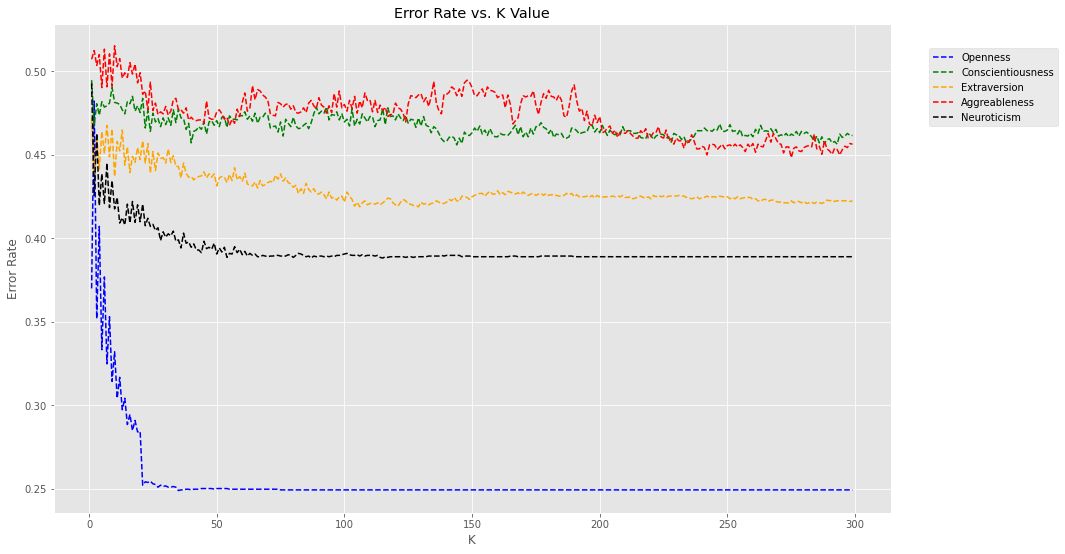

In [32]:
# Elbow method to determine the optimal K (n_neighbors)
error_rate_opn = []
error_rate_con = []
error_rate_ext = []
error_rate_agr = []
error_rate_neu = []

for i in range(1, 300):
    knn_opn = KNeighborsClassifier(n_neighbors=i)
    knn_opn.fit(X_OPN_train, y_OPN_train)
    pred_i = knn_opn.predict(X_OPN_test)
    error_rate_opn.append(numpy.mean(pred_i != numpy.asarray(y_OPN_test)))
    
    knn_con = KNeighborsClassifier(n_neighbors=i)
    knn_con.fit(X_CON_train, y_CON_train)
    pred_i = knn_con.predict(X_CON_test)
    error_rate_con.append(numpy.mean(pred_i != numpy.asarray(y_CON_test)))
    
    knn_ext = KNeighborsClassifier(n_neighbors=i)
    knn_ext.fit(X_EXT_train, y_EXT_train)
    pred_i = knn_ext.predict(X_EXT_test)
    error_rate_ext.append(numpy.mean(pred_i != numpy.asarray(y_EXT_test)))
    
    knn_agr = KNeighborsClassifier(n_neighbors=i)
    knn_agr.fit(X_AGR_train, y_AGR_train)
    pred_i = knn_agr.predict(X_AGR_test)
    error_rate_agr.append(numpy.mean(pred_i != numpy.asarray(y_AGR_test)))
    
    knn_neu = KNeighborsClassifier(n_neighbors=i)
    knn_neu.fit(X_NEU_train, y_NEU_train)
    pred_i = knn_neu.predict(X_NEU_test)
    error_rate_neu.append(numpy.mean(pred_i != numpy.asarray(y_NEU_test)))

# Plotting a Line graphs of the error rate
plt.figure(figsize=(15,9))
plt.plot(range(1, 300), error_rate_opn, color='blue', linestyle='dashed', label='Openness')
plt.plot(range(1, 300), error_rate_con, color='green', linestyle='dashed', label='Conscientiousness')
plt.plot(range(1, 300), error_rate_ext, color='orange', linestyle='dashed', label='Extraversion')
plt.plot(range(1, 300), error_rate_agr, color='red', linestyle='dashed', label='Aggreableness')
plt.plot(range(1, 300), error_rate_neu, color='black', linestyle='dashed', label='Neuroticism')
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.legend(bbox_to_anchor=(1.2, 0.95), loc='upper right', borderaxespad=0)
plt.show()

In [19]:
# Optimal K
n_neighbors_opn = 50
n_neighbors_con = 150
n_neighbors_ext = 150
n_neighbors_agr = 400
n_neighbors_neu = 100

In [20]:
# Lists of hyperparameters
leaf_size = list(range(1, 30))
p=[1, 2]
weights = ['uniform', 'distance'],
metric = ['minkowski', 'euclidean', 'manhattan']

# Hyperparameters dictionary
hyperparameters = dict(leaf_size=leaf_size, p=p, metric=metric)

In [21]:
# Build KNN classifiers for each personality trait with hyperparameter tuning
model_KNN_OPN = GridSearchCV(KNeighborsClassifier(n_neighbors=n_neighbors_opn), hyperparameters, scoring='accuracy', cv=5)
model_KNN_OPN = model_KNN_OPN.fit(X_OPN_train, y_OPN_train)
print("\n model_KNN_OPN: best estimator across ALL searched params:\n",model_KNN_OPN.best_estimator_)
print("\n model_KNN_OPN: best parameters across ALL searched params:\n",model_KNN_OPN.best_params_)

model_KNN_CON = GridSearchCV(KNeighborsClassifier(n_neighbors=n_neighbors_con), hyperparameters, scoring='accuracy', cv=5)
model_KNN_CON = model_KNN_CON.fit(X_CON_train, y_CON_train)
print("\n model_KNN_CON: best estimator across ALL searched params:\n",model_KNN_CON.best_estimator_)
print("\n model_KNN_CON: best parameters across ALL searched params:\n",model_KNN_CON.best_params_)

model_KNN_EXT = GridSearchCV(KNeighborsClassifier(n_neighbors=n_neighbors_ext), hyperparameters, scoring='accuracy', cv=5)
model_KNN_EXT = model_KNN_EXT.fit(X_EXT_train, y_EXT_train)
print("\n model_KNN_EXT: best estimator across ALL searched params:\n",model_KNN_EXT.best_estimator_)
print("\n model_KNN_EXT: best parameters across ALL searched params:\n",model_KNN_EXT.best_params_)

model_KNN_AGR = GridSearchCV(KNeighborsClassifier(n_neighbors=n_neighbors_agr), hyperparameters, scoring='accuracy', cv=5)
model_KNN_AGR = model_KNN_AGR.fit(X_AGR_train, y_AGR_train)
print("\n model_KNN_AGR: best estimator across ALL searched params:\n",model_KNN_AGR.best_estimator_)
print("\n model_KNN_AGR: best parameters across ALL searched params:\n",model_KNN_AGR.best_params_)

model_KNN_NEU = GridSearchCV(KNeighborsClassifier(n_neighbors=n_neighbors_neu), hyperparameters, scoring='accuracy', cv=5)
model_KNN_NEU = model_KNN_NEU.fit(X_NEU_train, y_NEU_train)
print("\n model_KNN_NEU: best estimator across ALL searched params:\n",model_KNN_NEU.best_estimator_)
print("\n model_KNN_NEU: best parameters across ALL searched params:\n",model_KNN_NEU.best_params_)


 model_KNN_OPN: best estimator across ALL searched params:
 KNeighborsClassifier(algorithm='auto', leaf_size=1, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=50, p=2,
                     weights='uniform')

 model_KNN_OPN: best parameters across ALL searched params:
 {'leaf_size': 1, 'metric': 'minkowski', 'p': 2}

 model_KNN_CON: best estimator across ALL searched params:
 KNeighborsClassifier(algorithm='auto', leaf_size=3, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=150, p=2,
                     weights='uniform')

 model_KNN_CON: best parameters across ALL searched params:
 {'leaf_size': 3, 'metric': 'minkowski', 'p': 2}

 model_KNN_EXT: best estimator across ALL searched params:
 KNeighborsClassifier(algorithm='auto', leaf_size=6, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=150, p=1,
                     weights='uniform')

 model_KNN_EXT: best parameters a

In [22]:
# Predict
output_KNN_OPN = model_KNN_OPN.predict(X_OPN_test)
output_KNN_CON = model_KNN_CON.predict(X_CON_test)
output_KNN_EXT = model_KNN_EXT.predict(X_EXT_test)
output_KNN_AGR = model_KNN_AGR.predict(X_AGR_test)
output_KNN_NEU = model_KNN_NEU.predict(X_NEU_test)

In [23]:
print_classification_reports(output_KNN_OPN, output_KNN_CON, output_KNN_EXT, output_KNN_AGR, output_KNN_NEU)

Openness---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       634
           1       0.74      1.00      0.85      1845

    accuracy                           0.74      2479
   macro avg       0.37      0.50      0.43      2479
weighted avg       0.55      0.74      0.64      2479

Conscientiousness---
              precision    recall  f1-score   support

           0       0.54      0.92      0.68      1330
           1       0.49      0.09      0.16      1149

    accuracy                           0.53      2479
   macro avg       0.52      0.50      0.42      2479
weighted avg       0.52      0.53      0.44      2479

Extraversion---
              precision    recall  f1-score   support

           0       0.58      0.98      0.73      1433
           1       0.42      0.02      0.04      1046

    accuracy                           0.57      2479
   macro avg       0.50      0.50      0.38      2479
weighted avg       0.51  

D:\Software\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
knn_model_accuracy = claculate_accuracy_scores(output_KNN_OPN, output_KNN_CON, output_KNN_EXT, output_KNN_AGR, output_KNN_NEU)
knn_model_accuracy

{'accuracy_opn': 0.7442517144009682,
 'accuracy_con': 0.5348931020572811,
 'accuracy_ext': 0.5748285599031868,
 'accuracy_agr': 0.5191609519967729,
 'accuracy_neu': 0.6349334409035902}

## Random Forest (RF)

In [21]:
params = {
    'max_depth': list(range(1, 25)),
    'min_samples_leaf': [5, 10, 20, 50, 100, 200],
    'n_estimators': [10, 25, 30, 50, 100, 150, 200, 250, 300, 400, 500],
    'max_depth': [int(x) for x in numpy.linspace(10, 110, num = 11)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [22]:
# Build RF classifiers for each personality trait with hyperparameter tuning
model_RF_OPN = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="roc_auc")
model_RF_OPN = model_RF_OPN.fit(X_OPN_train, y_OPN_train)
print("\n model_RF_OPN: best estimator across ALL searched params:\n",model_RF_OPN.best_estimator_)
print("\n model_RF_OPN: best parameters across ALL searched params:\n",model_RF_OPN.best_params_)

model_RF_CON = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="roc_auc")
model_RF_CON = model_RF_CON.fit(X_CON_train, y_CON_train)
print("\n model_RF_CON: best estimator across ALL searched params:\n",model_RF_CON.best_estimator_)
print("\n model_RF_CON: best parameters across ALL searched params:\n",model_RF_CON.best_params_)

model_RF_EXT = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="roc_auc")
model_RF_EXT = model_RF_EXT.fit(X_EXT_train, y_EXT_train)
print("\n model_RF_EXT: best estimator across ALL searched params:\n",model_RF_EXT.best_estimator_)
print("\n model_RF_EXT: best parameters across ALL searched params:\n",model_RF_EXT.best_params_)

model_RF_AGR = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="roc_auc")
model_RF_AGR = model_RF_AGR.fit(X_AGR_train, y_AGR_train)
print("\n model_RF_AGR: best estimator across ALL searched params:\n",model_RF_AGR.best_estimator_)
print("\n model_RF_AGR: best parameters across ALL searched params:\n",model_RF_AGR.best_params_)

model_RF_NEU = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), param_grid=params, cv = 4, n_jobs=-1, verbose=1, scoring="roc_auc")
model_RF_NEU = model_RF_NEU.fit(X_NEU_train, y_NEU_train)
print("\n model_RF_NEU: best estimator across ALL searched params:\n",model_RF_NEU.best_estimator_)
print("\n model_RF_NEU: best parameters across ALL searched params:\n",model_RF_NEU.best_params_)

Fitting 4 folds for each of 1089 candidates, totalling 4356 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 28.9min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 53.3min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 83.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 137.6min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 201.4min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 251.6min
[Parallel(n_jobs=-1)]: Done 4356 out of 4356 | elapsed: 271.6min finished



 model_RF_OPN: best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

 model_RF_OPN: best parameters across ALL searched params:
 {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}
Fitting 4 folds for each of 1089 candidates, totalling 4356 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 26.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 64.8min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 90.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 119.8min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 152.1min
[Parallel(n_jobs=-1)]: Done 4356 out of 4356 | elapsed: 164.9min finished



 model_RF_CON: best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

 model_RF_CON: best parameters across ALL searched params:
 {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Fitting 4 folds for each of 1089 candidates, totalling 4356 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 11.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 41.1min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 61.3min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 85.8min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 113.6min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 145.6min
[Parallel(n_jobs=-1)]: Done 4356 out of 4356 | elapsed: 158.3min finished



 model_RF_EXT: best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

 model_RF_EXT: best parameters across ALL searched params:
 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 25}
Fitting 4 folds for each of 1089 candidates, totalling 4356 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 23.7min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 60.3min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 84.3min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 112.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 143.8min
[Parallel(n_jobs=-1)]: Done 4356 out of 4356 | elapsed: 156.3min finished



 model_RF_AGR: best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

 model_RF_AGR: best parameters across ALL searched params:
 {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 30}
Fitting 4 folds for each of 1089 candidates, totalling 4356 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 11.6min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed: 63.0min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed: 88.2min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed: 116.9min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 149.6min
[Parallel(n_jobs=-1)]: Done 4356 out of 4356 | elapsed: 162.6min finished



 model_RF_NEU: best estimator across ALL searched params:
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

 model_RF_NEU: best parameters across ALL searched params:
 {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}


In [23]:
# Predict
output_RF_OPN = model_RF_OPN.predict(X_OPN_test)
output_RF_CON = model_RF_CON.predict(X_CON_test)
output_RF_EXT = model_RF_EXT.predict(X_EXT_test)
output_RF_AGR = model_RF_AGR.predict(X_AGR_test)
output_RF_NEU = model_RF_NEU.predict(X_NEU_test)

In [24]:
print_classification_reports(output_RF_OPN, output_RF_CON, output_RF_EXT, output_RF_AGR, output_RF_NEU)

Openness---
              precision    recall  f1-score   support

           0       0.43      0.03      0.05       635
           1       0.75      0.99      0.85      1844

    accuracy                           0.74      2479
   macro avg       0.59      0.51      0.45      2479
weighted avg       0.67      0.74      0.64      2479

Conscientiousness---
              precision    recall  f1-score   support

           0       0.54      0.75      0.63      1325
           1       0.49      0.28      0.36      1154

    accuracy                           0.53      2479
   macro avg       0.52      0.52      0.49      2479
weighted avg       0.52      0.53      0.50      2479

Extraversion---
              precision    recall  f1-score   support

           0       0.58      0.90      0.70      1426
           1       0.45      0.12      0.19      1053

    accuracy                           0.57      2479
   macro avg       0.52      0.51      0.44      2479
weighted avg       0.53  

In [25]:
rf_model_accuracy = claculate_accuracy_scores(output_RF_OPN, output_RF_CON, output_RF_EXT, output_RF_AGR, output_RF_NEU)
rf_model_accuracy

{'accuracy_opn': 0.7418313836224284,
 'accuracy_con': 0.5316659943525616,
 'accuracy_ext': 0.5651472367890278,
 'accuracy_agr': 0.536103267446551,
 'accuracy_neu': 0.6200080677692618}

## Support Vector Machine (SVM)

In [27]:
param_grid = {
    'C': [0.1,1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

In [28]:
# Build SVM classifiers for each personality trait with hyperparameter tuning
model_SVM_OPN = GridSearchCV(SVC(), param_grid, refit=True, scoring='accuracy', verbose=2)
model_SVM_OPN = model_SVM_OPN.fit(X_OPN_train, y_OPN_train)
print("\n model_SVM_OPN: best estimator across ALL searched params:\n",model_SVM_OPN.best_estimator_)
print("\n model_SVM_OPN: best parameters across ALL searched params:\n",model_SVM_OPN.best_params_)

model_SVM_CON = GridSearchCV(SVC(), param_grid, refit=True, scoring='accuracy', verbose=2)
model_SVM_CON = model_SVM_CON.fit(X_CON_train, y_CON_train)
print("\n model_SVM_CON: best estimator across ALL searched params:\n",model_SVM_CON.best_estimator_)
print("\n model_SVM_CON: best parameters across ALL searched params:\n",model_SVM_CON.best_params_)

model_SVM_EXT = GridSearchCV(SVC(), param_grid, refit=True, scoring='accuracy', verbose=2)
model_SVM_EXT = model_SVM_EXT.fit(X_EXT_train, y_EXT_train)
print("\n model_SVM_EXT: best estimator across ALL searched params:\n",model_SVM_EXT.best_estimator_)
print("\n model_SVM_EXT: best parameters across ALL searched params:\n",model_SVM_EXT.best_params_)

model_SVM_AGR = GridSearchCV(SVC(), param_grid, refit=True, scoring='accuracy', verbose=2)
model_SVM_AGR = model_SVM_AGR.fit(X_AGR_train, y_AGR_train)
print("\n model_SVM_AGR: best estimator across ALL searched params:\n",model_SVM_AGR.best_estimator_)
print("\n model_SVM_AGR: best parameters across ALL searched params:\n",model_SVM_AGR.best_params_)

model_SVM_NEU = GridSearchCV(SVC(), param_grid, refit=True, scoring='accuracy', verbose=2)
model_SVM_NEU = model_SVM_NEU.fit(X_NEU_train, y_NEU_train)
print("\n model_SVM_NEU: best estimator across ALL searched params:\n",model_SVM_NEU.best_estimator_)
print("\n model_SVM_NEU: best parameters across ALL searched params:\n",model_SVM_NEU.best_params_)

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  12.5s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.4s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  12.2s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  11.1s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  10.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=   9.9s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   8.9s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   9.3s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=   8.7s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=   9.4s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   9.4s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   9.3s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   9.6s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   9.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=   9.4s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] ................. C=0.1, gamma=0.0001, kernel=poly, total=   8.8s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] .

[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   8.8s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   9.1s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=   8.6s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   8.7s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   8.6s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   8.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=   8.6s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   8.5s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   8.4s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   8.5s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   8.4s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=   8.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   8.2s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=   8.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] ...................... C=100, gamma=1, kernel=poly, total=   7.6s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=   7.7s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   8.8s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   8.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   8.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   9.0s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=   8.8s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   7.7s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   7.6s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   7.6s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=   7.6s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   7.8s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   7.7s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=   7.8s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .

[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=  10.6s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   7.6s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   7.6s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   7.6s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   7.6s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=   7.6s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .............. C=1000, gamma=0.001, kernel=sigmoid, total=   8.5s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 55.0min finished



 model_SVM_OPN: best estimator across ALL searched params:
 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 model_SVM_OPN: best parameters across ALL searched params:
 {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  14.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.8s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  14.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  14.8s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  14.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  14.8s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  14.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  14.1s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  14.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=  15.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  14.7s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  14.8s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  14.9s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  15.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  14.7s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] ................. C=0.1, gamma=0.0001, kernel=poly, total=  14.0s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] .

[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  16.3s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  15.3s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  15.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  16.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  15.7s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  15.3s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  15.3s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  17.7s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  16.9s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  16.9s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  17.6s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  17.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=  17.1s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=  17.7s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] ...................... C=100, gamma=1, kernel=poly, total=  16.1s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=  16.1s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  18.2s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  17.7s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  17.6s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  17.5s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  17.6s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  15.9s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  15.9s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  15.9s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  16.2s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=  16.5s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=  16.2s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=  16.1s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .

[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=  17.6s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  16.0s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  16.0s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  16.0s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  15.9s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  16.0s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .............. C=1000, gamma=0.001, kernel=sigmoid, total=  17.1s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 101.4min finished



 model_SVM_CON: best estimator across ALL searched params:
 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 model_SVM_CON: best parameters across ALL searched params:
 {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.6s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.6s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.9s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.7s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.6s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  14.8s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  15.0s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  14.9s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=  17.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  16.2s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  16.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  15.9s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  16.4s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  15.7s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] ................. C=0.1, gamma=0.0001, kernel=poly, total=  14.8s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] .

[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  16.5s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  15.8s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  16.0s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  15.7s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  15.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  15.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  16.6s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  13.7s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  13.9s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  13.7s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  13.7s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  13.7s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=  13.7s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=  13.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] ...................... C=100, gamma=1, kernel=poly, total=  13.0s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=  13.0s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  15.1s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  14.6s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  14.7s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  14.8s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  14.9s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  12.9s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  13.0s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  12.9s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  12.8s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=  13.0s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=  13.2s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=  13.2s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .

[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=  14.4s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  12.8s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  12.9s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  12.9s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  13.0s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  12.9s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .............. C=1000, gamma=0.001, kernel=sigmoid, total=  13.8s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 89.9min finished



 model_SVM_EXT: best estimator across ALL searched params:
 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 model_SVM_EXT: best parameters across ALL searched params:
 {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.2s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.4s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.3s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  15.3s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  14.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  14.6s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  14.4s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=  15.4s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  15.2s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  15.3s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  15.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  15.3s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  15.1s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] ................. C=0.1, gamma=0.0001, kernel=poly, total=  14.3s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] .

[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  15.3s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  15.3s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  15.3s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  15.8s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  15.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  15.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  15.5s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  16.1s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  15.9s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  15.7s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  15.7s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  15.8s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=  15.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=  15.3s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] ...................... C=100, gamma=1, kernel=poly, total=  14.6s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=  14.4s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  15.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  15.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  16.0s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  15.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  15.8s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  14.3s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  14.2s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  14.4s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  14.4s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=  14.6s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=  14.6s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=  14.6s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .

[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=  16.1s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  14.3s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  14.3s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  14.3s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  14.3s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  14.5s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .............. C=1000, gamma=0.001, kernel=sigmoid, total=  15.8s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 94.6min finished



 model_SVM_AGR: best estimator across ALL searched params:
 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 model_SVM_AGR: best parameters across ALL searched params:
 {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  12.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.9s remaining:    0.0s


[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  12.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  12.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  12.0s
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] ....................... C=0.1, gamma=1, kernel=rbf, total=  11.9s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  11.6s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  11.3s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] ...................... C=0.1, gamma=1, kernel=poly, total=  11.3s
[CV] C=0.1, gamma=1, kernel=poly .....................................
[CV] .

[CV] ............... C=0.1, gamma=0.001, kernel=sigmoid, total=  12.1s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  12.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  12.0s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  11.9s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  11.9s
[CV] C=0.1, gamma=0.0001, kernel=rbf .................................
[CV] .................. C=0.1, gamma=0.0001, kernel=rbf, total=  12.0s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] ................. C=0.1, gamma=0.0001, kernel=poly, total=  11.2s
[CV] C=0.1, gamma=0.0001, kernel=poly ................................
[CV] .

[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  12.2s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  12.0s
[CV] C=1, gamma=0.01, kernel=sigmoid .................................
[CV] .................. C=1, gamma=0.01, kernel=sigmoid, total=  12.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  12.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  12.2s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  12.4s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] ..................... C=1, gamma=0.001, kernel=rbf, total=  12.3s
[CV] C=1, gamma=0.001, kernel=rbf ....................................
[CV] .

[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  12.7s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  12.5s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  12.9s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  13.0s
[CV] C=10, gamma=0.1, kernel=sigmoid .................................
[CV] .................. C=10, gamma=0.1, kernel=sigmoid, total=  12.9s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=  12.7s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] ..................... C=10, gamma=0.01, kernel=rbf, total=  13.4s
[CV] C=10, gamma=0.01, kernel=rbf ....................................
[CV] .

[CV] ...................... C=100, gamma=1, kernel=poly, total=  12.3s
[CV] C=100, gamma=1, kernel=poly .....................................
[CV] ...................... C=100, gamma=1, kernel=poly, total=  12.4s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  14.0s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  14.1s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  13.8s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  13.9s
[CV] C=100, gamma=1, kernel=sigmoid ..................................
[CV] ................... C=100, gamma=1, kernel=sigmoid, total=  13.8s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] .

[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  12.6s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  12.3s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  12.4s
[CV] C=100, gamma=0.0001, kernel=poly ................................
[CV] ................. C=100, gamma=0.0001, kernel=poly, total=  12.4s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=  12.5s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=  12.5s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .............. C=100, gamma=0.0001, kernel=sigmoid, total=  12.5s
[CV] C=100, gamma=0.0001, kernel=sigmoid .............................
[CV] .

[CV] .................. C=1000, gamma=0.001, kernel=rbf, total=  14.0s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  12.4s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  12.6s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  12.7s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  12.5s
[CV] C=1000, gamma=0.001, kernel=poly ................................
[CV] ................. C=1000, gamma=0.001, kernel=poly, total=  12.5s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .............. C=1000, gamma=0.001, kernel=sigmoid, total=  13.4s
[CV] C=1000, gamma=0.001, kernel=sigmoid .............................
[CV] .

[Parallel(n_jobs=1)]: Done 375 out of 375 | elapsed: 79.3min finished



 model_SVM_NEU: best estimator across ALL searched params:
 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

 model_SVM_NEU: best parameters across ALL searched params:
 {'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}


In [29]:
# Predict
output_SVM_OPN = model_SVM_OPN.predict(X_OPN_test)
output_SVM_CON = model_SVM_CON.predict(X_CON_test)
output_SVM_EXT = model_SVM_EXT.predict(X_EXT_test)
output_SVM_AGR = model_SVM_AGR.predict(X_AGR_test)
output_SVM_NEU = model_SVM_NEU.predict(X_NEU_test)

In [30]:
print_classification_reports(output_SVM_OPN, output_SVM_CON, output_SVM_EXT, output_SVM_AGR, output_SVM_NEU)

Openness---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       635
           1       0.74      1.00      0.85      1844

    accuracy                           0.74      2479
   macro avg       0.37      0.50      0.43      2479
weighted avg       0.55      0.74      0.63      2479

Conscientiousness---
              precision    recall  f1-score   support

           0       0.53      1.00      0.70      1325
           1       0.00      0.00      0.00      1154

    accuracy                           0.53      2479
   macro avg       0.27      0.50      0.35      2479
weighted avg       0.29      0.53      0.37      2479

Extraversion---
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      1426
           1       0.00      0.00      0.00      1053

    accuracy                           0.58      2479
   macro avg       0.29      0.50      0.37      2479
weighted avg       0.33  

D:\Software\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
svm_model_accuracy = claculate_accuracy_scores(output_SVM_OPN, output_SVM_CON, output_SVM_EXT, output_SVM_AGR, output_SVM_NEU)
svm_model_accuracy

{'accuracy_opn': 0.7438483259378782,
 'accuracy_con': 0.5344897135941912,
 'accuracy_ext': 0.5752319483662768,
 'accuracy_agr': 0.5336829366680113,
 'accuracy_neu': 0.6216216216216216}

## Gaussian Naive Bayes

In [19]:
param_grid = {
    'var_smoothing': numpy.logspace(0,-9, num=100)
}

In [20]:
# Build Naive Bayes classifiers for each personality trait with hyperparameter tuning
model_GNB_OPN = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, verbose=1, cv=10, scoring='accuracy', n_jobs=-1)
model_GNB_OPN = model_GNB_OPN.fit(X_OPN_train, y_OPN_train)
print("\n model_GNB_OPN: best estimator across ALL searched params:\n",model_GNB_OPN.best_estimator_)
print("\n model_GNB_OPN: best parameters across ALL searched params:\n",model_GNB_OPN.best_params_)

model_GNB_CON = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, verbose=1, cv=10, scoring='accuracy', n_jobs=-1)
model_GNB_CON = model_GNB_CON.fit(X_CON_train, y_CON_train)
print("\n model_GNB_CON: best estimator across ALL searched params:\n",model_GNB_CON.best_estimator_)
print("\n model_GNB_CON: best parameters across ALL searched params:\n",model_GNB_CON.best_params_)

model_GNB_EXT = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, verbose=1, cv=10, scoring='accuracy', n_jobs=-1)
model_GNB_EXT = model_GNB_EXT.fit(X_EXT_train, y_EXT_train)
print("\n model_GNB_EXT: best estimator across ALL searched params:\n",model_GNB_EXT.best_estimator_)
print("\n model_GNB_EXT: best parameters across ALL searched params:\n",model_GNB_EXT.best_params_)

model_GNB_AGR = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, verbose=1, cv=10, scoring='accuracy', n_jobs=-1)
model_GNB_AGR = model_GNB_AGR.fit(X_AGR_train, y_AGR_train)
print("\n model_GNB_AGR: best estimator across ALL searched params:\n",model_GNB_AGR.best_estimator_)
print("\n model_GNB_AGR: best parameters across ALL searched params:\n",model_GNB_AGR.best_params_)

model_GNB_NEU = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, verbose=1, cv=10, scoring='accuracy', n_jobs=-1)
model_GNB_NEU = model_GNB_NEU.fit(X_NEU_train, y_NEU_train)
print("\n model_GNB_NEU: best estimator across ALL searched params:\n",model_GNB_NEU.best_estimator_)
print("\n model_GNB_NEU: best parameters across ALL searched params:\n",model_GNB_NEU.best_params_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



 model_GNB_OPN: best estimator across ALL searched params:
 GaussianNB(priors=None, var_smoothing=1.0)

 model_GNB_OPN: best parameters across ALL searched params:
 {'var_smoothing': 1.0}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



 model_GNB_CON: best estimator across ALL searched params:
 GaussianNB(priors=None, var_smoothing=0.0533669923120631)

 model_GNB_CON: best parameters across ALL searched params:
 {'var_smoothing': 0.0533669923120631}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



 model_GNB_EXT: best estimator across ALL searched params:
 GaussianNB(priors=None, var_smoothing=1.0)

 model_GNB_EXT: best parameters across ALL searched params:
 {'var_smoothing': 1.0}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.



 model_GNB_AGR: best estimator across ALL searched params:
 GaussianNB(priors=None, var_smoothing=0.657933224657568)

 model_GNB_AGR: best parameters across ALL searched params:
 {'var_smoothing': 0.657933224657568}
Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   34.4s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.5min



 model_GNB_NEU: best estimator across ALL searched params:
 GaussianNB(priors=None, var_smoothing=1.0)

 model_GNB_NEU: best parameters across ALL searched params:
 {'var_smoothing': 1.0}


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.2min finished


In [21]:
# Predict
output_GNB_OPN = model_GNB_OPN.predict(X_OPN_test)
output_GNB_CON = model_GNB_CON.predict(X_CON_test)
output_GNB_EXT = model_GNB_EXT.predict(X_EXT_test)
output_GNB_AGR = model_GNB_AGR.predict(X_AGR_test)
output_GNB_NEU = model_GNB_NEU.predict(X_NEU_test)

In [22]:
print_classification_reports(output_GNB_OPN, output_GNB_CON, output_GNB_EXT, output_GNB_AGR, output_GNB_NEU)

Openness---
              precision    recall  f1-score   support

           0       0.29      0.06      0.10       672
           1       0.73      0.94      0.82      1807

    accuracy                           0.70      2479
   macro avg       0.51      0.50      0.46      2479
weighted avg       0.61      0.70      0.63      2479

Conscientiousness---
              precision    recall  f1-score   support

           0       0.53      0.73      0.61      1312
           1       0.46      0.26      0.34      1167

    accuracy                           0.51      2479
   macro avg       0.49      0.50      0.47      2479
weighted avg       0.50      0.51      0.48      2479

Extraversion---
              precision    recall  f1-score   support

           0       0.58      0.86      0.69      1439
           1       0.39      0.12      0.19      1040

    accuracy                           0.55      2479
   macro avg       0.48      0.49      0.44      2479
weighted avg       0.50  

In [23]:
gnb_model_accuracy = claculate_accuracy_scores(output_GNB_OPN, output_GNB_CON, output_GNB_EXT, output_GNB_AGR, output_GNB_NEU)
gnb_model_accuracy

{'accuracy_opn': 0.7047196450181524,
 'accuracy_con': 0.509479628882614,
 'accuracy_ext': 0.5522388059701493,
 'accuracy_agr': 0.5135135135135135,
 'accuracy_neu': 0.6147640177490924}

## Pickling the Models

In [26]:
# Pickling Doc2Vec Models
with open('pickle_files/v3/model_opn_d2v.pickle', 'wb') as files:
  pickle.dump(model_OPN_d2v, files)

with open('pickle_files/v3/model_con_d2v.pickle', 'wb') as files:
  pickle.dump(model_CON_d2v, files)

with open('pickle_files/v3/model_ext_d2v.pickle', 'wb') as files:
  pickle.dump(model_EXT_d2v, files)

with open('pickle_files/v3/model_agr_d2v.pickle', 'wb') as files:
  pickle.dump(model_AGR_d2v, files)

with open('pickle_files/v3/model_neu_d2v.pickle', 'wb') as files:
  pickle.dump(model_NEU_d2v, files)

In [ ]:
# Pickling LR Models
with open('pickle_files/v3/ppf_lr_opn.pickle', 'wb') as files:
  pickle.dump(model_LR_OPN, files)

with open('pickle_files/v3/ppf_lr_con.pickle', 'wb') as files:
  pickle.dump(model_LR_CON, files)

with open('pickle_files/v3/ppf_lr_ext.pickle', 'wb') as files:
  pickle.dump(model_LR_EXT, files)

with open('pickle_files/v3/ppf_lr_agr.pickle', 'wb') as files:
  pickle.dump(model_LR_AGR, files)

with open('pickle_files/v3/ppf_lr_neu.pickle', 'wb') as files:
  pickle.dump(model_LR_NEU, files)

In [25]:
# Pickling KNN Models
with open('pickle_files/v3/ppf_knn_opn.pickle', 'wb') as files:
  pickle.dump(model_KNN_OPN, files)

with open('pickle_files/v3/ppf_knn_con.pickle', 'wb') as files:
  pickle.dump(model_KNN_CON, files)

with open('pickle_files/v3/ppf_knn_ext.pickle', 'wb') as files:
  pickle.dump(model_KNN_EXT, files)

with open('pickle_files/v3/ppf_knn_agr.pickle', 'wb') as files:
  pickle.dump(model_KNN_AGR, files)

with open('pickle_files/v3/ppf_knn_neu.pickle', 'wb') as files:
  pickle.dump(model_KNN_NEU, files)

In [26]:
# Pickling RF Models
with open('pickle_files/v3/ppf_rf_opn.pickle', 'wb') as files:
  pickle.dump(model_RF_OPN, files)

with open('pickle_files/v3/ppf_rf_con.pickle', 'wb') as files:
  pickle.dump(model_RF_CON, files)

with open('pickle_files/v3/ppf_rf_ext.pickle', 'wb') as files:
  pickle.dump(model_RF_EXT, files)

with open('pickle_files/v3/ppf_rf_agr.pickle', 'wb') as files:
  pickle.dump(model_RF_AGR, files)

with open('pickle_files/v3/ppf_rf_neu.pickle', 'wb') as files:
  pickle.dump(model_RF_NEU, files)

In [32]:
# Pickling SVM Models
with open('pickle_files/v3/ppf_svm_opn.pickle', 'wb') as files:
  pickle.dump(model_SVM_OPN, files)

with open('pickle_files/v3/ppf_svm_con.pickle', 'wb') as files:
  pickle.dump(model_SVM_CON, files)

with open('pickle_files/v3/ppf_svm_ext.pickle', 'wb') as files:
  pickle.dump(model_SVM_EXT, files)

with open('pickle_files/v3/ppf_svm_agr.pickle', 'wb') as files:
  pickle.dump(model_SVM_AGR, files)

with open('pickle_files/v3/ppf_svm_neu.pickle', 'wb') as files:
  pickle.dump(model_SVM_NEU, files)

In [24]:
# Pickling GNB Models
with open('pickle_files/v3/ppf_gnb_opn.pickle', 'wb') as files:
  pickle.dump(model_GNB_OPN, files)

with open('pickle_files/v3/ppf_gnb_con.pickle', 'wb') as files:
  pickle.dump(model_GNB_CON, files)

with open('pickle_files/v3/ppf_gnb_ext.pickle', 'wb') as files:
  pickle.dump(model_GNB_EXT, files)

with open('pickle_files/v3/ppf_gnb_agr.pickle', 'wb') as files:
  pickle.dump(model_GNB_AGR, files)

with open('pickle_files/v3/ppf_gnb_neu.pickle', 'wb') as files:
  pickle.dump(model_GNB_NEU, files)

## Model Comparison
Comparison of accuracy of the Machine Learning models trained for each Big-Five personality trait.

In [1]:
models = ['LR', 'KNN', 'RF', 'SVM', 'GNB']

In [2]:
lr_model_accuracy = {'accuracy_opn': 0.7587736990722065,
 'accuracy_con': 0.5437676482452601,
 'accuracy_ext': 0.5687777329568374,
 'accuracy_agr': 0.5518354175070593,
 'accuracy_neu': 0.6345300524405002}
knn_model_accuracy = {'accuracy_opn': 0.7442517144009682,
 'accuracy_con': 0.5348931020572811,
 'accuracy_ext': 0.5748285599031868,
 'accuracy_agr': 0.5191609519967729,
 'accuracy_neu': 0.6349334409035902}
rf_model_accuracy = {'accuracy_opn': 0.7418313836224284,
 'accuracy_con': 0.5316659943525616,
 'accuracy_ext': 0.5651472367890278,
 'accuracy_agr': 0.536103267446551,
 'accuracy_neu': 0.6200080677692618}
svm_model_accuracy = {'accuracy_opn': 0.7438483259378782,
 'accuracy_con': 0.5344897135941912,
 'accuracy_ext': 0.5752319483662768,
 'accuracy_agr': 0.5336829366680113,
 'accuracy_neu': 0.6216216216216216}
gnb_model_accuracy = {'accuracy_opn': 0.7047196450181524,
 'accuracy_con': 0.509479628882614,
 'accuracy_ext': 0.5522388059701493,
 'accuracy_agr': 0.5135135135135135,
 'accuracy_neu': 0.6147640177490924}

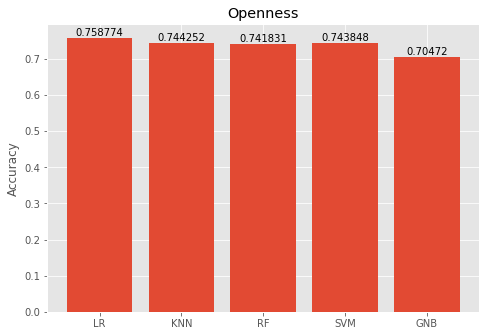

In [6]:
# Openness
lr_model_accuracy_opn = lr_model_accuracy['accuracy_opn']
knn_model_accuracy_opn = knn_model_accuracy['accuracy_opn']
rf_model_accuracy_opn = rf_model_accuracy['accuracy_opn']
svm_model_accuracy_opn = svm_model_accuracy['accuracy_opn']
gnb_model_accuracy_opn = gnb_model_accuracy['accuracy_opn']

accuracies = [lr_model_accuracy_opn, knn_model_accuracy_opn, rf_model_accuracy_opn, svm_model_accuracy_opn, gnb_model_accuracy_opn]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Accuracy')
ax.set_title('Openness')
bars = ax.bar(models, accuracies)
ax.bar_label(bars)
plt.show()

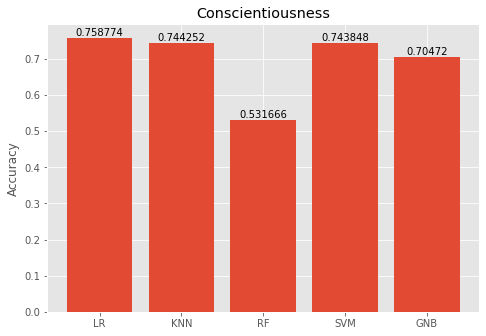

In [7]:
# Conscientiousness
lr_model_accuracy_con = lr_model_accuracy['accuracy_con']
knn_model_accuracy_con = knn_model_accuracy['accuracy_con']
rf_model_accuracy_con = rf_model_accuracy['accuracy_con']
svm_model_accuracy_con = svm_model_accuracy['accuracy_con']
gnb_model_accuracy_con = gnb_model_accuracy['accuracy_con']

accuracies = [lr_model_accuracy_opn, knn_model_accuracy_opn, rf_model_accuracy_con, svm_model_accuracy_opn, gnb_model_accuracy_opn]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Accuracy')
ax.set_title('Conscientiousness')
bars = ax.bar(models, accuracies)
ax.bar_label(bars)
plt.show()

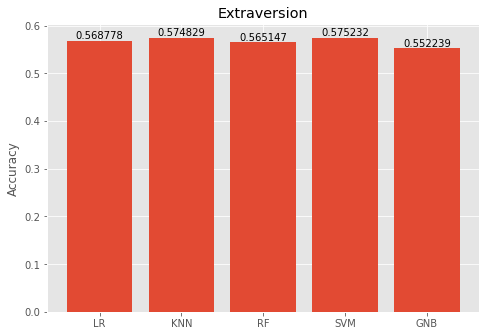

In [8]:
# Extraversion
lr_model_accuracy_ext = lr_model_accuracy['accuracy_ext']
knn_model_accuracy_ext = knn_model_accuracy['accuracy_ext']
rf_model_accuracy_ext = rf_model_accuracy['accuracy_ext']
svm_model_accuracy_ext = svm_model_accuracy['accuracy_ext']
gnb_model_accuracy_ext = gnb_model_accuracy['accuracy_ext']

accuracies = [lr_model_accuracy_ext, knn_model_accuracy_ext, rf_model_accuracy_ext, svm_model_accuracy_ext, gnb_model_accuracy_ext]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Accuracy')
ax.set_title('Extraversion')
bars = ax.bar(models, accuracies)
ax.bar_label(bars)
plt.show()

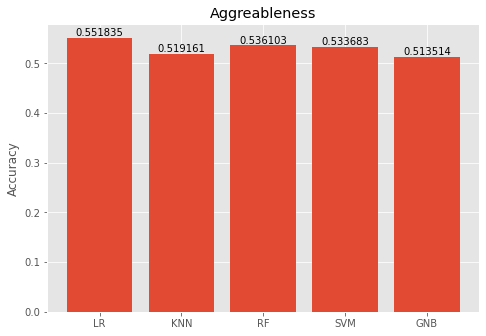

In [9]:
# Aggreableness
lr_model_accuracy_agr = lr_model_accuracy['accuracy_agr']
knn_model_accuracy_agr = knn_model_accuracy['accuracy_agr']
rf_model_accuracy_agr = rf_model_accuracy['accuracy_agr']
svm_model_accuracy_agr = svm_model_accuracy['accuracy_agr']
gnb_model_accuracy_agr = gnb_model_accuracy['accuracy_agr']

accuracies = [lr_model_accuracy_agr, knn_model_accuracy_agr, rf_model_accuracy_agr, svm_model_accuracy_agr, gnb_model_accuracy_agr]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Accuracy')
ax.set_title('Aggreableness')
bars = ax.bar(models, accuracies)
ax.bar_label(bars)
plt.show()

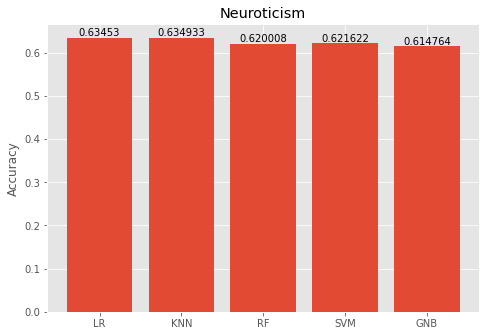

In [10]:
# Neuroticism
lr_model_accuracy_neu = lr_model_accuracy['accuracy_neu']
knn_model_accuracy_neu = knn_model_accuracy['accuracy_neu']
rf_model_accuracy_neu = rf_model_accuracy['accuracy_neu']
svm_model_accuracy_neu = svm_model_accuracy['accuracy_neu']
gnb_model_accuracy_neu = gnb_model_accuracy['accuracy_neu']

accuracies = [lr_model_accuracy_neu, knn_model_accuracy_neu, rf_model_accuracy_neu, svm_model_accuracy_neu, gnb_model_accuracy_neu]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Accuracy')
ax.set_title('Neuroticism')
bars = ax.bar(models, accuracies)
ax.bar_label(bars)
plt.show()